In [1]:
%pip install shap --quiet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [23]:
import os, json, numpy as np, pandas as pd, joblib, shap, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

plt.rcParams["figure.figsize"] = (8,5)
RANDOM_STATE = 42

DATA_CLEAN  = "../data/processed/loan_approval_clean.csv"
MODELS_DIR  = "../models"
REPORTS_DIR = "../reports"
FIG_DIR     = os.path.join(REPORTS_DIR, "figures")

os.makedirs(REPORTS_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

In [24]:
df = pd.read_csv(DATA_CLEAN)
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

# normalize/validate target
label_map = {"approved": 1, "rejected": 0}
t = df["loan_status"].astype("string").str.strip().str.lower()
mask = t.isin(label_map)
df, t = df.loc[mask].reset_index(drop=True), t.loc[mask].reset_index(drop=True)

y = t.map(label_map).astype(int)
X = df.drop(columns=["loan_status", "loan_id"], errors="ignore")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)

print("Train/Test shapes:", X_train.shape, X_test.shape)

Train/Test shapes: (3415, 11) (854, 11)


In [25]:

best_name = None
metrics_path = os.path.join(REPORTS_DIR, "metrics.json")
if os.path.exists(metrics_path):
    with open(metrics_path) as f:
        all_metrics = json.load(f)
    def score_key(m): return (m.get("roc_auc", 0.0), m.get("f1", 0.0))
    best_name = max(all_metrics, key=lambda k: score_key(all_metrics[k]))
if best_name is None:
    best_name = "random_forest"  

model_path = os.path.join(MODELS_DIR, f"{best_name}.pkl")
print("Loading:", model_path)
model = joblib.load(model_path)

print(classification_report(y_test, model.predict(X_test), digits=3))

Loading: ../models\random_forest.pkl
              precision    recall  f1-score   support

           0      0.978     0.972     0.975       323
           1      0.983     0.987     0.985       531

    accuracy                          0.981       854
   macro avg      0.981     0.979     0.980       854
weighted avg      0.981     0.981     0.981       854



In [26]:
prep = model.named_steps["prep"]
clf  = model.named_steps["clf"]

num_cols = prep.transformers_[0][2] if len(prep.transformers_)>0 else []
cat_cols = prep.transformers_[1][2] if len(prep.transformers_)>1 else []

nums = prep.named_transformers_.get("num")
cats = prep.named_transformers_.get("cat")

num_names = nums.get_feature_names_out(num_cols).tolist() if nums is not None else []
cat_names = cats.get_feature_names_out(cat_cols).tolist() if cats is not None else []
feature_names = num_names + cat_names

print("Transformed feature count:", len(feature_names))

Transformed feature count: 13


In [27]:
Xt_train = prep.transform(X_train)
Xt_test  = prep.transform(X_test)

try:
    Xt_train = Xt_train.toarray()
    Xt_test  = Xt_test.toarray()
except Exception:
    pass

rng = np.random.RandomState(RANDOM_STATE)
N_BG = min(1000, Xt_train.shape[0])
N_EX = min(500,  Xt_test.shape[0])

bg_idx = rng.choice(Xt_train.shape[0], N_BG, replace=False)
ex_idx = rng.choice(Xt_test.shape[0],  N_EX, replace=False)

Xt_bg, Xt_ex = Xt_train[bg_idx], Xt_test[ex_idx]
y_ex = y_test.iloc[ex_idx].to_numpy()

print("BG/EX shapes:", Xt_bg.shape, Xt_ex.shape)

BG/EX shapes: (1000, 13) (500, 13)


In [28]:
def make_explainer(clf, background):
    name = clf.__class__.__name__.lower()

    if any(k in name for k in ["randomforest","gradientboost","xgb","lightgbm","extratrees"]):
        return shap.TreeExplainer(
            clf,
            data=background,                      
            feature_perturbation="interventional",
            model_output="probability"           
        )
    if "logisticregression" in name:
        return shap.LinearExplainer(clf, background)
    return shap.Explainer(clf, background)

explainer = make_explainer(clf, Xt_bg)

shap_vals = explainer(Xt_ex, check_additivity=False)

sv = shap_vals[1].values if isinstance(shap_vals, list) else shap_vals.values

print("sv shape:", sv.shape, "| Xt_ex shape:", Xt_ex.shape, "| features:", len(feature_names))
assert sv.shape[1] == Xt_ex.shape[1] == len(feature_names)

 99%|===================| 993/1000 [01:01<00:00]        

sv shape: (500, 13, 2) | Xt_ex shape: (500, 13) | features: 13


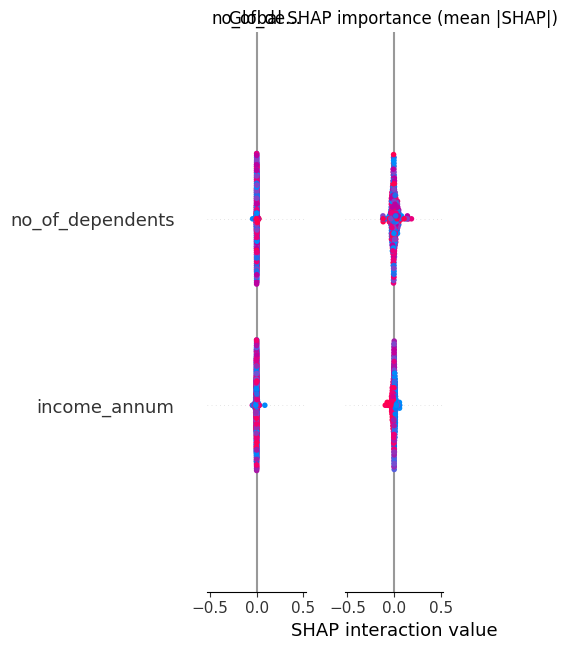

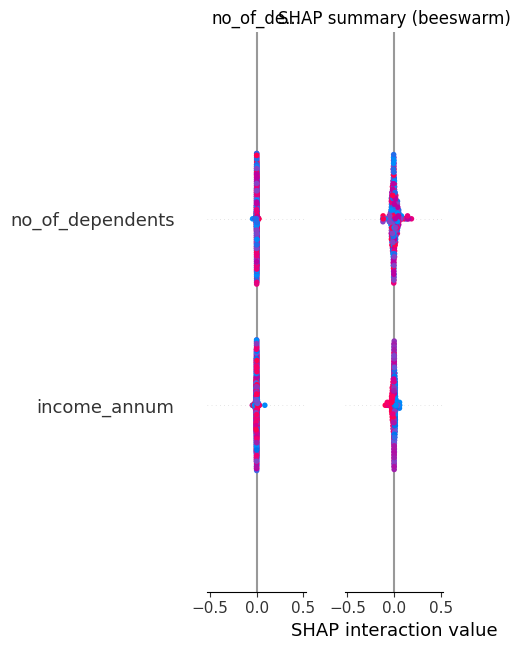

In [29]:

shap.summary_plot(sv, Xt_ex, feature_names=feature_names, plot_type="bar", show=False)
plt.title("Global SHAP importance (mean |SHAP|)")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "shap_global_bar.png"), dpi=160)
plt.show()

shap.summary_plot(sv, Xt_ex, feature_names=feature_names, show=False)
plt.title("SHAP summary (beeswarm)")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "shap_global_beeswarm.png"), dpi=160, bbox_inches="tight")
plt.show()

In [36]:
if isinstance(shap_vals, list):
    sv = shap_vals[1] if hasattr(shap_vals[1], "values") else shap_vals[1]
    sv = sv.values if hasattr(sv, "values") else sv
else:
    sv = shap_vals.values if hasattr(shap_vals, "values") else shap_vals

if sv.ndim == 3 and sv.shape[-1] == 2:
    sv = sv[:, :, 1]

sv = np.asarray(sv)
print("Final SHAP shape:", sv.shape) 

Final SHAP shape: (500, 13)


Top features: ['cibil_score', 'loan_term', 'loan_amount', 'income_annum', 'luxury_assets_value']


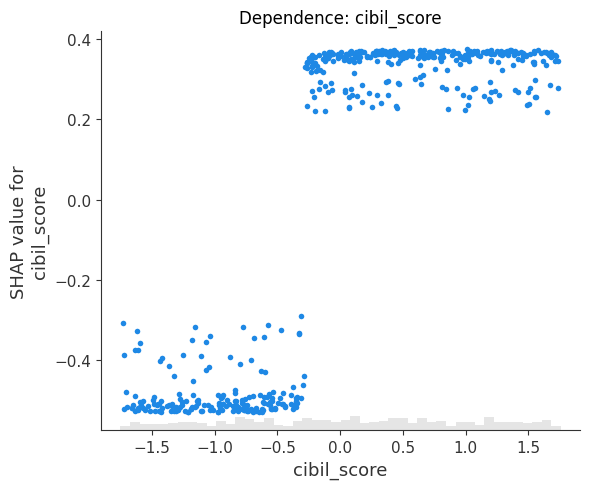

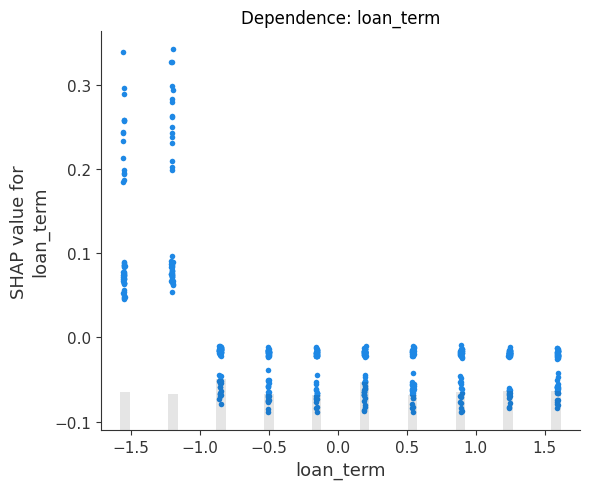

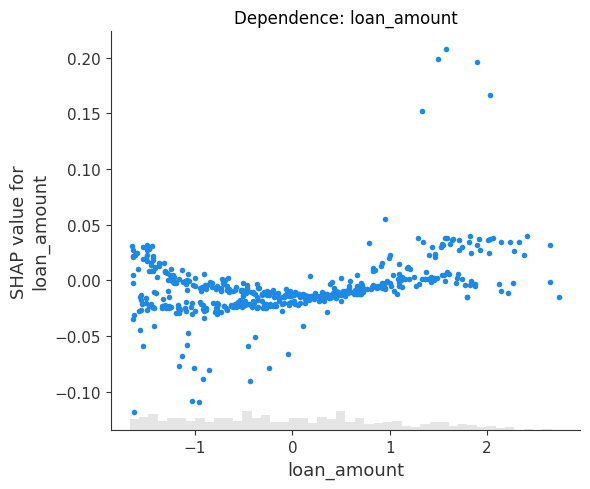

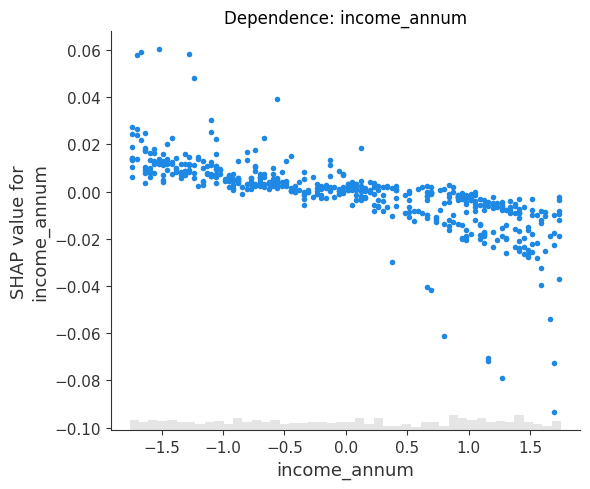

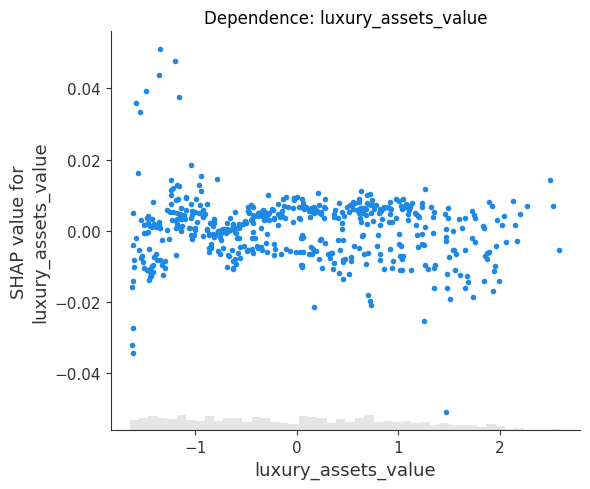

In [37]:
mean_abs = np.abs(sv).mean(axis=0)

order = np.argsort(-mean_abs)[:5]
top_feats = [feature_names[i] for i in order]
print("Top features:", top_feats)

for i, name in zip(order, top_feats):
    try:
        expl = shap.Explanation(values=sv, data=Xt_ex, feature_names=feature_names)
        shap.plots.scatter(expl[:, i], show=False) 
    except Exception:
        shap.dependence_plot(i, sv, Xt_ex, feature_names=feature_names,
                             interaction_index=None, show=False)  
    
    plt.title(f"Dependence: {name}")
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, f"shap_dependence_{name.replace('/','_')}.png"),
                dpi=160, bbox_inches="tight")
    plt.show()

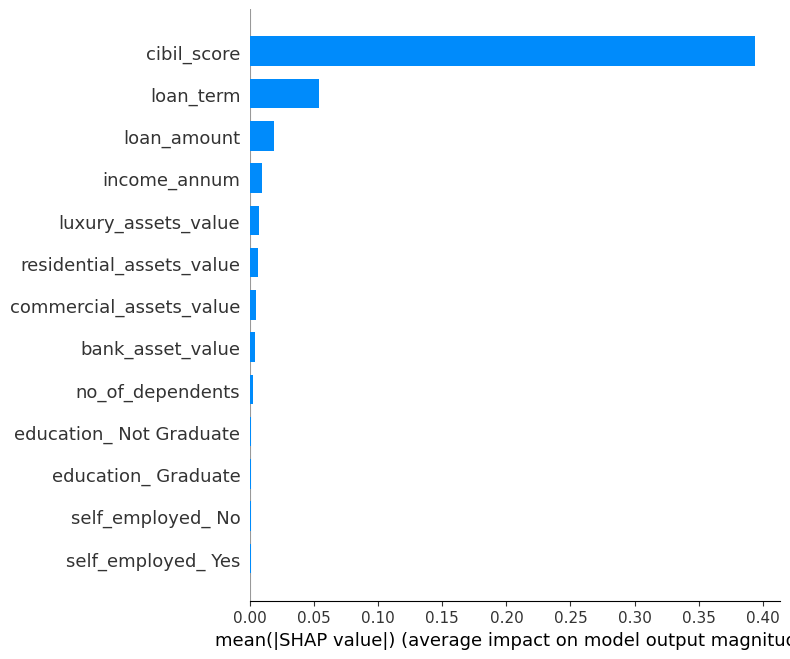

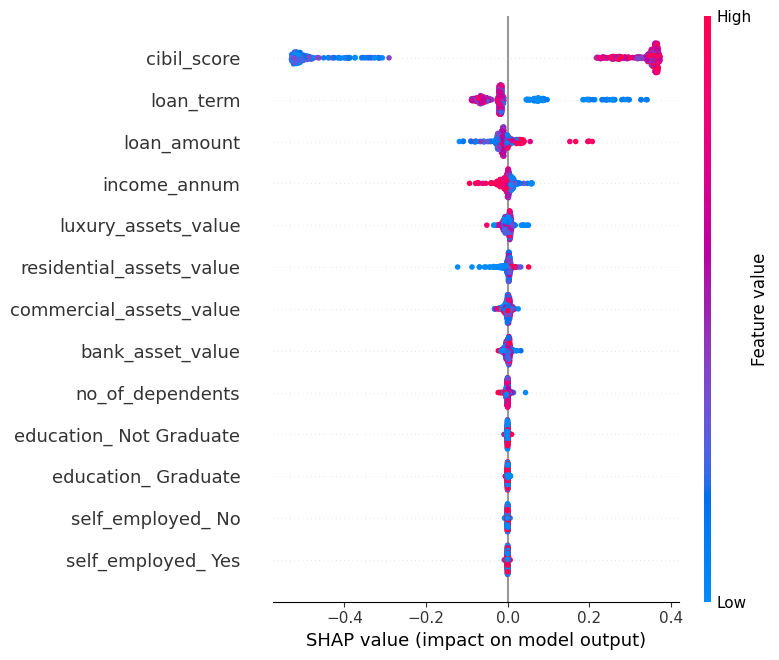

In [38]:

plt.figure()
shap.summary_plot(sv, Xt_ex, feature_names=feature_names, plot_type="bar", show=False)
plt.savefig(os.path.join(FIG_DIR, "shap_global_bar.png"), dpi=160, bbox_inches="tight")
plt.show()

plt.figure()
shap.summary_plot(sv, Xt_ex, feature_names=feature_names, show=False)
plt.savefig(os.path.join(FIG_DIR, "shap_global_beeswarm.png"), dpi=160, bbox_inches="tight")
plt.show()

In [ ]:

i = 0  
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value[1],
    sv[i],
    feature_names=feature_names,
    max_display=10
)
plt.savefig(os.path.join(FIG_DIR, f"shap_local_ex_{i}.png"), dpi=160, bbox_inches="tight")
plt.show()
